# preface 
I was inspired by @AmbrosM idea https://www.kaggle.com/competitions/ariel-data-challenge-2024/discussion/530152#2969648

The idea of ​​this approach is to predict the average answer for each test sample. Instead of building models, we will search for the correct answer experimentally. We will select for each spectrum such a multiplier that the transit part multiplied by it will "line up" with the other points. The line can be either a straight line or a polynomial up to the 5th degree. For selection, we will use the Nelder-Mead method. The found multiplication factor minus one is our answer.

There are some changes in data preparation here.
* dt for dark calibration changed in favor https://www.kaggle.com/code/gordonyip/update-calibrating-and-binning-astronomical-data/comments#2964759
* signal clipped to zero due this https://www.kaggle.com/competitions/ariel-data-challenge-2024/discussion/530247#2970709
* I masked hot and dead pixels with NaN in flat and averaging through spatial dimension.

### **upd for version 2**: it seems I forgot to remove **5x sigma** copied from somewhere. I wonder how this will affect the score.

### preprocess the data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats
from tqdm import tqdm

from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error
import itertools
from scipy.optimize import minimize
from functools import partial
import random, os
from astropy.stats import sigma_clip

In [2]:
test_adc_info = pd.read_csv('/kaggle/input/ariel-data-challenge-2024/test_adc_info.csv',
                           index_col='planet_id')
axis_info = pd.read_parquet('/kaggle/input/ariel-data-challenge-2024/axis_info.parquet')

In [3]:
def apply_linear_corr(linear_corr,clean_signal):
    linear_corr = np.flip(linear_corr, axis=0)
    for x, y in itertools.product(
                range(clean_signal.shape[1]), range(clean_signal.shape[2])
            ):
        poli = np.poly1d(linear_corr[:, x, y])
        clean_signal[:, x, y] = poli(clean_signal[:, x, y])
    return clean_signal

def clean_dark(signal, dark, dt):
    dark = np.tile(dark, (signal.shape[0], 1, 1))
    signal -= dark* dt[:, np.newaxis, np.newaxis]
    return signal

def preproc(dataset, adc_info, sensor, binning = 15):
    cut_inf, cut_sup = 39, 321
    sensor_sizes_dict = {"AIRS-CH0":[[11250, 32, 356], [1, 32, cut_sup-cut_inf]], "FGS1":[[135000, 32, 32], [1, 32, 32]]}
    binned_dict = {"AIRS-CH0":[11250 // binning // 2, 282], "FGS1":[135000 // binning // 2]}
    linear_corr_dict = {"AIRS-CH0":(6, 32, 356), "FGS1":(6, 32, 32)}
    planet_ids = adc_info.index
    
    feats = []
    for i, planet_id in tqdm(list(enumerate(planet_ids))):
        signal = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2024/{dataset}/{planet_id}/{sensor}_signal.parquet').to_numpy()
        dark_frame = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2024/{dataset}/' + str(planet_id) + '/' + sensor + '_calibration/dark.parquet', engine='pyarrow').to_numpy()
        dead_frame = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2024/{dataset}/' + str(planet_id) + '/' + sensor + '_calibration/dead.parquet', engine='pyarrow').to_numpy()
        flat_frame = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2024/{dataset}/' + str(planet_id) + '/' + sensor + '_calibration/flat.parquet', engine='pyarrow').to_numpy()
        linear_corr = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2024/{dataset}/' + str(planet_id) + '/' + sensor + '_calibration/linear_corr.parquet').values.astype(np.float64).reshape(linear_corr_dict[sensor])

        signal = signal.reshape(sensor_sizes_dict[sensor][0]) 
        gain = adc_info[f'{sensor}_adc_gain'].values[i]
        offset = adc_info[f'{sensor}_adc_offset'].values[i]
        signal = signal / gain + offset
        
        hot = sigma_clip(
            dark_frame, sigma=5, maxiters=5
        ).mask
        
        if sensor != "FGS1":
            signal = signal[:, :, cut_inf:cut_sup] #11250 * 32 * 282
            #dt = axis_info['AIRS-CH0-integration_time'].dropna().values
            dt = np.ones(len(signal))*0.1 
            dt[1::2] += 4.5 #@bilzard idea
            linear_corr = linear_corr[:, :, cut_inf:cut_sup]
            dark_frame = dark_frame[:, cut_inf:cut_sup]
            dead_frame = dead_frame[:, cut_inf:cut_sup]
            flat_frame = flat_frame[:, cut_inf:cut_sup]
            hot = hot[:, cut_inf:cut_sup]
        else:
            dt = np.ones(len(signal))*0.1
            dt[1::2] += 0.1
            
        signal = signal.clip(0) #@graySnow idea
        linear_corr_signal = apply_linear_corr(linear_corr, signal)
        signal = clean_dark(linear_corr_signal, dark_frame, dt)
        
        flat = flat_frame.reshape(sensor_sizes_dict[sensor][1])
        flat[dead_frame.reshape(sensor_sizes_dict[sensor][1])] = np.nan
        flat[hot.reshape(sensor_sizes_dict[sensor][1])] = np.nan
        signal = signal / flat
        
        if sensor == "FGS1":
            signal = signal.reshape((sensor_sizes_dict[sensor][0][0], sensor_sizes_dict[sensor][0][1]*sensor_sizes_dict[sensor][0][2]))
        
        mean_signal = np.nanmean(signal, axis=1) # mean over the 32*32(FGS1) or 32(CH0) pixels
        cds_signal = (mean_signal[1::2] - mean_signal[0::2])
        
        binned = np.zeros((binned_dict[sensor]))
        for j in range(cds_signal.shape[0] // binning):
            binned[j] = cds_signal[j*binning:j*binning+binning].mean(axis=0)
                   
        if sensor == "FGS1":
            binned = binned.reshape((binned.shape[0],1))
            
        feats.append(binned)
        
    return np.stack(feats)
    
pre_train = np.concatenate([preproc('test', test_adc_info, "FGS1", 30*12), preproc('test', test_adc_info, "AIRS-CH0", 30)], axis=2)

100%|██████████| 1/1 [00:06<00:00,  6.67s/it]


### fit polynoms for each sample

In [4]:
def phase_detector(signal):
    phase1, phase2 = None, None
    best_drop = 0
    for i in range(50//2,150//2):        
        t1 = signal[i:i+20//2].max() - signal[i:i+20//2].min()
        if t1 > best_drop:
            phase1 = i+(20+5)//2
            best_drop = t1
    
    best_drop = 0
    for i in range(200//2,250//2):
        t1 = signal[i:i+20//2].max() - signal[i:i+20//2].min()
        if t1 > best_drop:
            phase2 = i-5//2
            best_drop = t1
    
    return phase1, phase2

def try_s(signal, p1, p2, deg, s):
    out = list(range(p1-30)) + list(range(p2+30,signal.shape[0]))
    x, y = out, signal[out].tolist()
    x = x + list(range(p1,p2))

    y = y + (signal[p1:p2] * (1 + s[0])).tolist()
    z = np.polyfit(x, y, deg)
    p = np.poly1d(z)
    q = np.abs(p(x) - y).mean()

    if s < 1e-4:
        return q + 1e3

    return q
    
def calibrate_signal(signal):
    p1,p2 = phase_detector(signal)

    best_deg, best_score = 1, 1e12
    for deg in range(1, 6):
        f = partial(try_s, signal, p1, p2, deg)
        r = minimize(f, [0.001], method = 'Nelder-Mead')
        s = r.x[0]

        out = list(range(p1-30)) + list(range(p2+30,signal.shape[0]))
        x, y = out, signal[out].tolist()
        x = x + list(range(p1,p2))
        y = y + (signal[p1:p2] * (1 + s)).tolist()
    
        z = np.polyfit(x, y, deg)
        p = np.poly1d(z)
        q = np.abs(p(x) - y).mean()
        
        if q < best_score:
            best_score = q
            best_deg = deg
        
        print(deg, q)
            
    z = np.polyfit(x, y, best_deg)
    p = np.poly1d(z)

    return s, x, y, p(x)

def calibrate_train(signal):
    p1,p2 = phase_detector(signal)
    
    best_deg, best_score = 1, 1e12
    for deg in range(1, 6):
        f = partial(try_s, signal, p1, p2, deg)
        r = minimize(f, [0.001], method = 'Nelder-Mead')
        s = r.x[0]

        out = list(range(p1-30)) + list(range(p2+30,signal.shape[0]))
        x, y = out, signal[out].tolist()
        x = x + list(range(p1,p2))
        y = y + (signal[p1:p2] * (1 + s)).tolist()
    
        z = np.polyfit(x, y, deg)
        p = np.poly1d(z)
        q = np.abs(p(x) - y).mean()
        
        if q < best_score:
            best_score = q
            best_deg = deg
            
    z = np.polyfit(x, y, best_deg)
    p = np.poly1d(z)
    
    return s, p(np.arange(signal.shape[0])), p1, p2


train = pre_train.copy()
all_s = []
for i in range(len(test_adc_info)):
    signal = train[i,:,1:].mean(axis=1)
    s, p, p1, p2 = calibrate_train(pre_train[i,:,1:].mean(axis=1))
    all_s.append(s)
        
#copy answer 283 times because we predict mean value
train_s = np.repeat(np.array(all_s), 283).reshape((len(all_s), 283))        
train_sigma = np.ones_like(train_s) * 0.00016

Probably we can accurately estimate sigma from train

1 0.07244656257090913
2 0.06997614558677229
3 0.06340499597848703
4 0.06369586726506939
5 0.06329606118528834


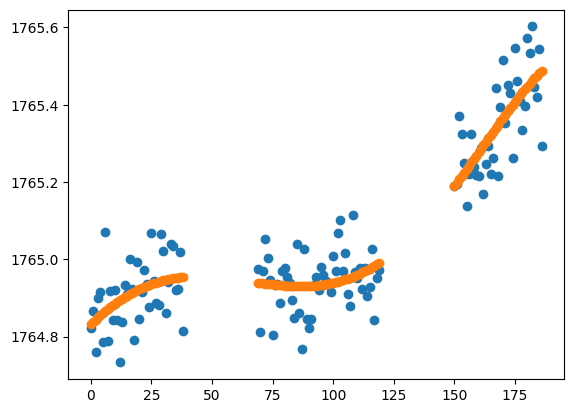

In [5]:
n = 0
s, x, y, y_new = calibrate_signal(pre_train[n,:,1:].mean(axis=1))
plt.scatter(x,y)
plt.scatter(x,y_new)

I call the orange line "starline". This is probably what we would see if the planet weren't in the way.

### Making submission

In [6]:
ss = pd.read_csv('/kaggle/input/ariel-data-challenge-2024/sample_submission.csv')

preds = train_s.clip(0)
sigmas = train_sigma
submission = pd.DataFrame(np.concatenate([preds,sigmas], axis=1), columns=ss.columns[1:])
submission.index = test_adc_info.index
submission.to_csv('submission.csv')

In [7]:
submission

,wl_1,wl_2,wl_3,wl_4,wl_5,wl_6,wl_7,wl_8,wl_9,wl_10,...,sigma_274,sigma_275,sigma_276,sigma_277,sigma_278,sigma_279,sigma_280,sigma_281,sigma_282,sigma_283
planet_id,,,,,,,,,,,,,,,,,,,,,
499191466,0.00265,0.00265,0.00265,0.00265,0.00265,0.00265,0.00265,0.00265,0.00265,0.00265,...,0.00016,0.00016,0.00016,0.00016,0.00016,0.00016,0.00016,0.00016,0.00016,0.00016
